In [1]:
from core.analysis import *
from core.metrics import *
import numpy as np
import pandas as pd

<Figure size 432x288 with 0 Axes>

## Data Prep

Reading in experimental data to see which words to run the model on

In [2]:
db = access_db()
results, incl_users = get_results_elig_users(db, 'Self Consistency', 0.2)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [8]:
test_repeat_lem_cnt = get_lemma_counts(results, incl_users, db)
test_words = test_repeat_lem_cnt[test_repeat_lem_cnt['num_trials'] > 10]['lemma']

## Modeling

In [16]:
model_data = {}
test_stats = []
incorrect = []
for w in test_words:
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                               use_masc = False, delim = '_')
    model_data[w] = model_results
    test_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

Fitting model for door_n
Running CV for door_n
Fitting model for world_n
Running CV for world_n
Fitting model for ask_v
Running CV for ask_v
Fitting model for indicate_v
Running CV for indicate_v
Fitting model for consider_v
Running CV for consider_v
Fitting model for case_n
Running CV for case_n
Fitting model for glass_n
Running CV for glass_n


/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting model for book_n
Running CV for book_n


/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting model for school_n
Running CV for school_n
Fitting model for put_v
Running CV for put_v
Fitting model for area_n
Running CV for area_n
Fitting model for cover_v
Running CV for cover_v
Fitting model for drive_v
Running CV for drive_v
Fitting model for raise_v
Running CV for raise_v
Fitting model for life_n
Running CV for life_n
Fitting model for produce_v
Running CV for produce_v
Fitting model for begin_v
Running CV for begin_v
Fitting model for death_n
Running CV for death_n
Fitting model for light_n
Running CV for light_n
Fitting model for time_n
Running CV for time_n
Fitting model for face_n
Running CV for face_n
Fitting model for heart_n
Running CV for heart_n


Accuracies and F1 scores for Test Words for 5 fold Cross Validation 

In [20]:
pd.DataFrame(test_stats).sort_values('avg_f1', ascending = False)

,word,avg_f1,avg_acc
10,area_n,0.923264,0.926586
2,ask_v,0.908155,0.909395
13,raise_v,0.877413,0.880882
18,light_n,0.855730,0.856044
8,school_n,0.835513,0.859852
21,heart_n,0.821001,0.833333
7,book_n,0.796155,0.842424
20,face_n,0.762401,0.803202
19,time_n,0.760433,0.764646
6,glass_n,0.756947,0.789286


## Confusion Matrices

We plot the results from the experiment with the cosine similarity of the BERT centroids, as well as the confusion matrices for the classification task. 

In [54]:
import seaborn as sns

In [136]:
def get_test_result_data(results, w, incl_users):
    test_means = mean_distance_mtx(results, w, 'test', incl_users, normalize = True)
    repeat_means = mean_distance_mtx(results, w, 'repeat', incl_users, normalize = True)
    expt_means = np.mean([test_means, repeat_means], axis = 0)
    expt_means /= np.max(expt_means)
    return expt_means

In [176]:
from matplotlib.backends.backend_pdf import PdfPages

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


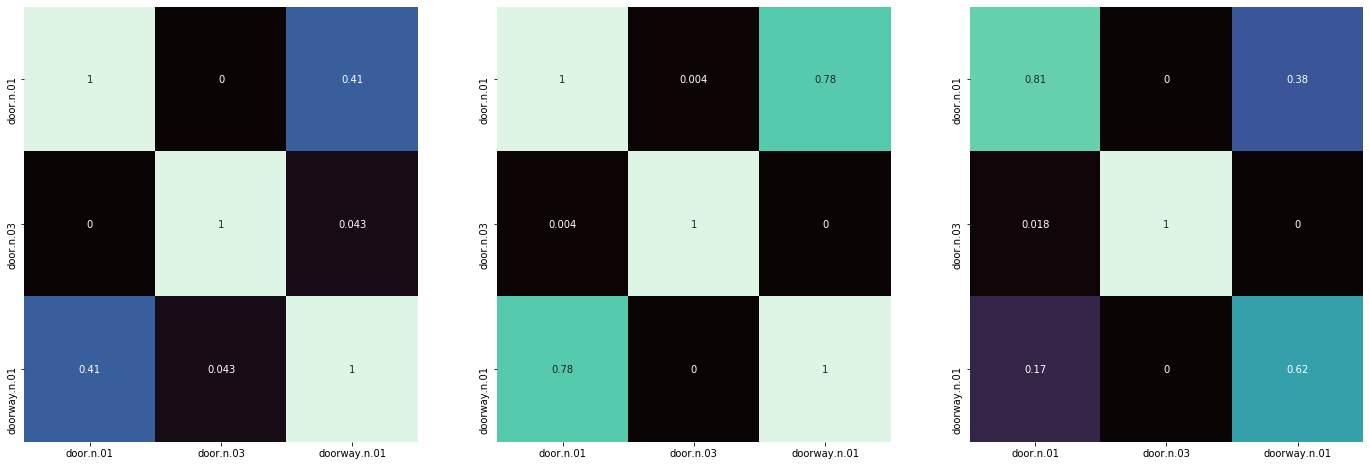

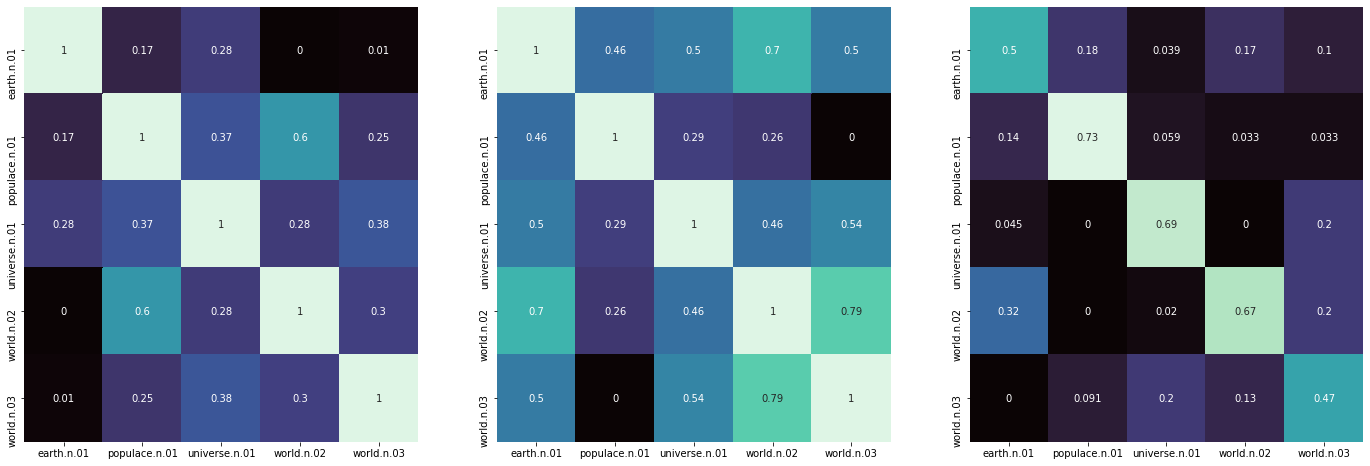

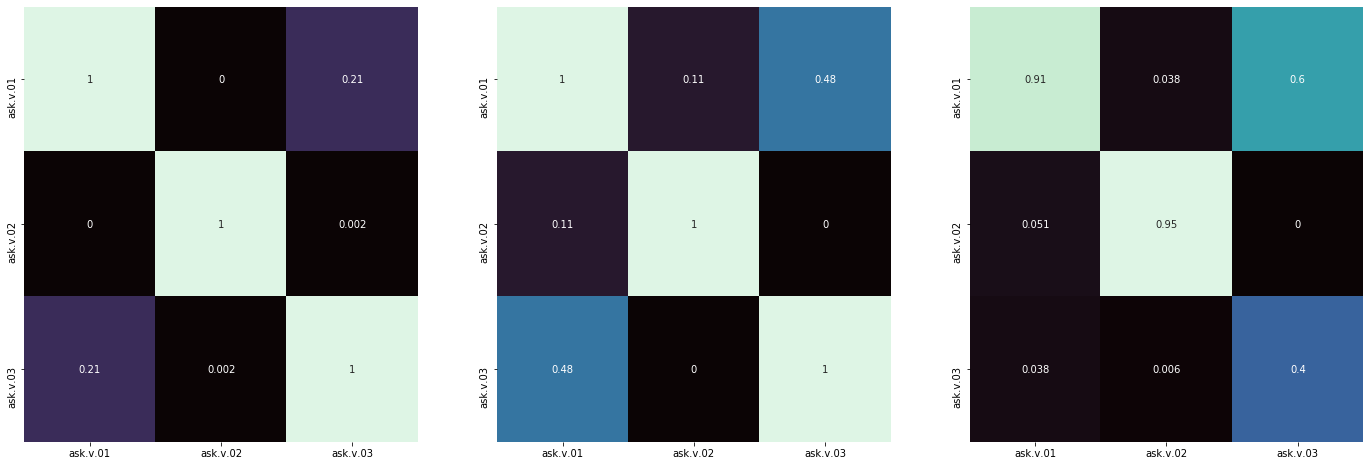

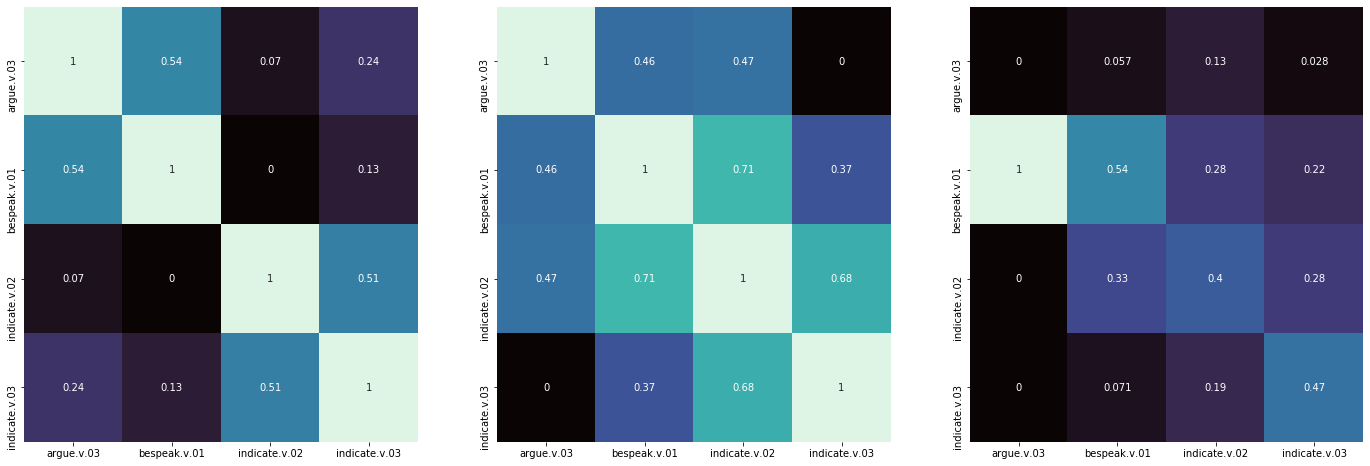

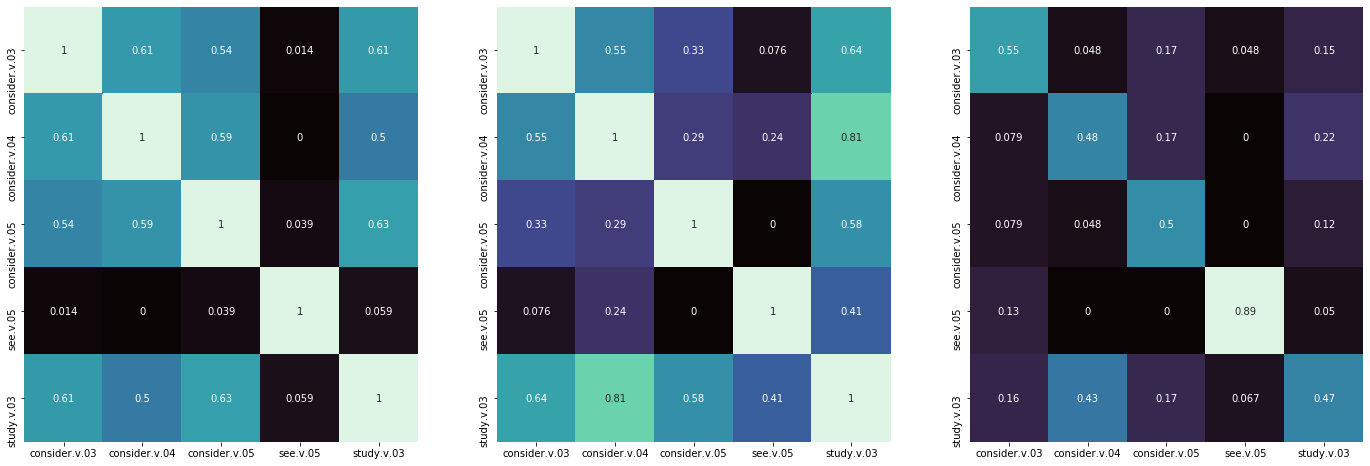

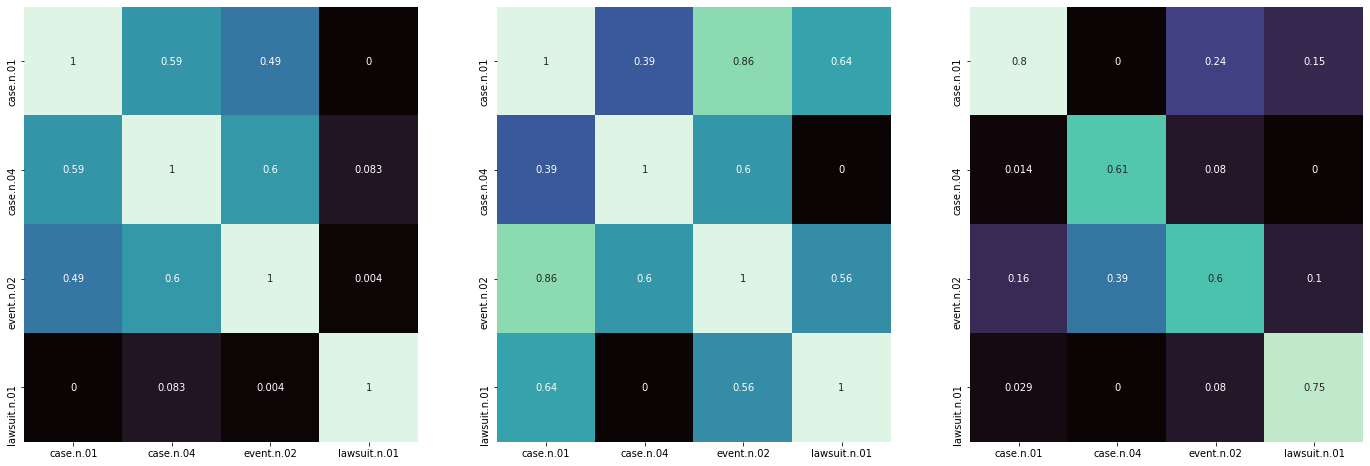

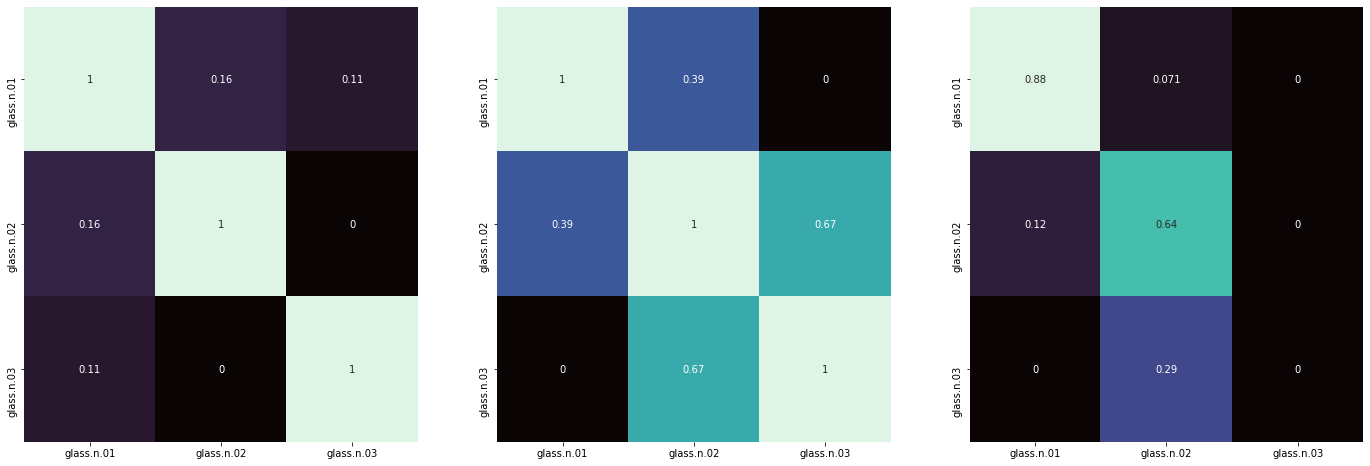

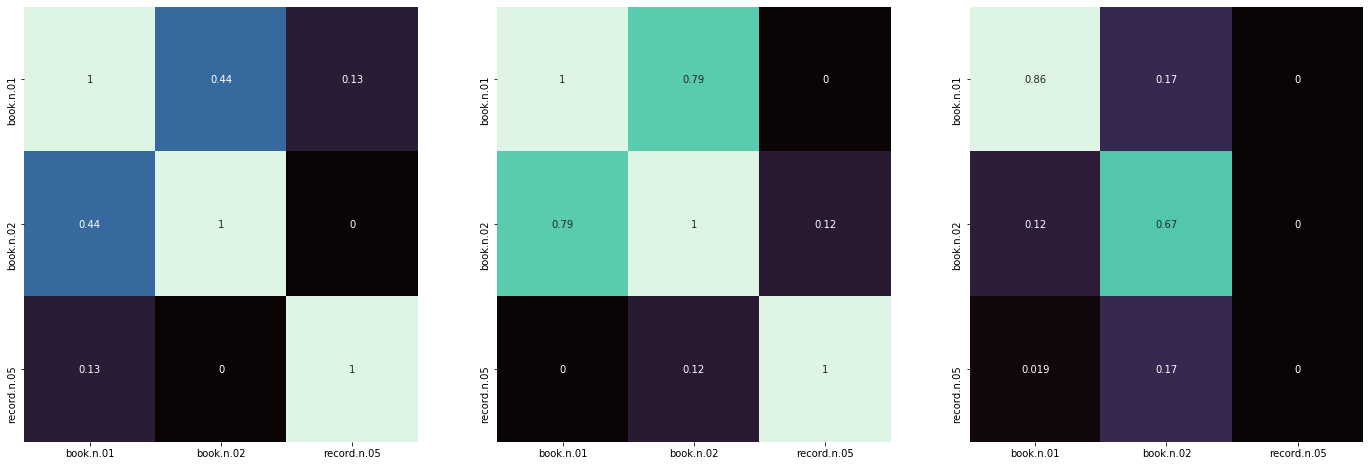

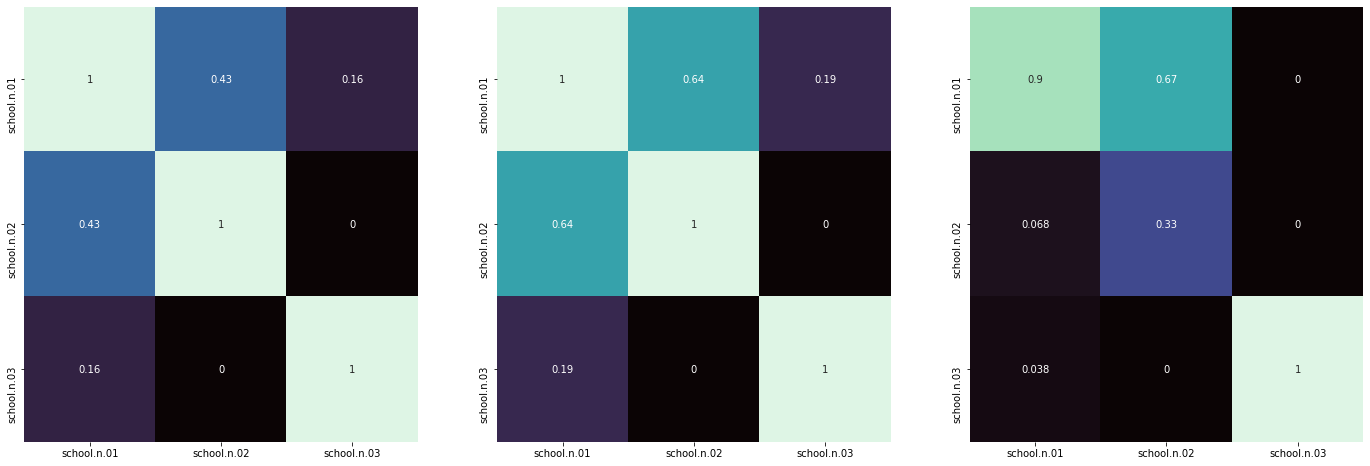

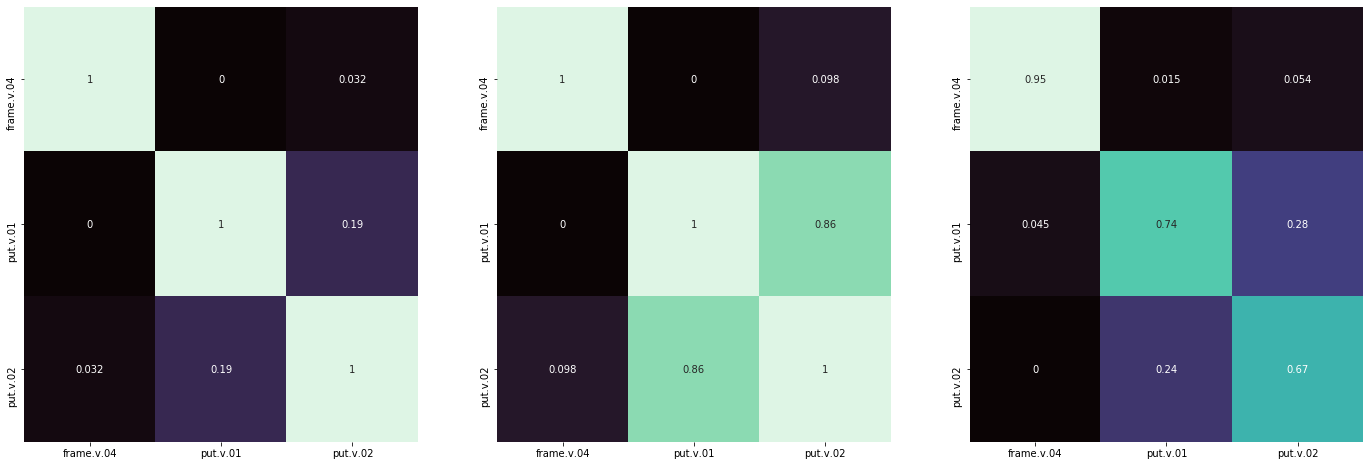

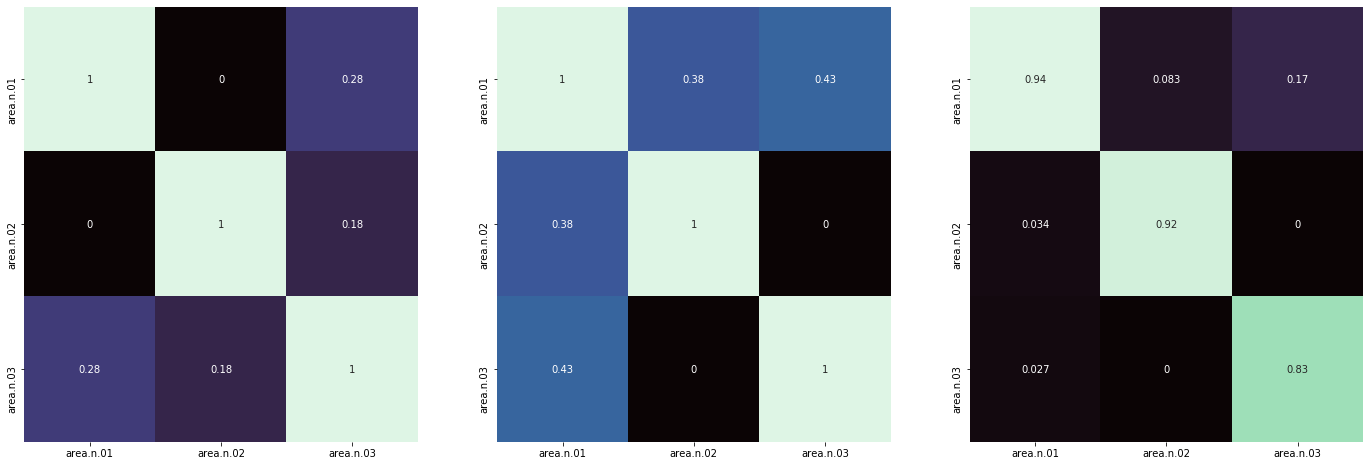

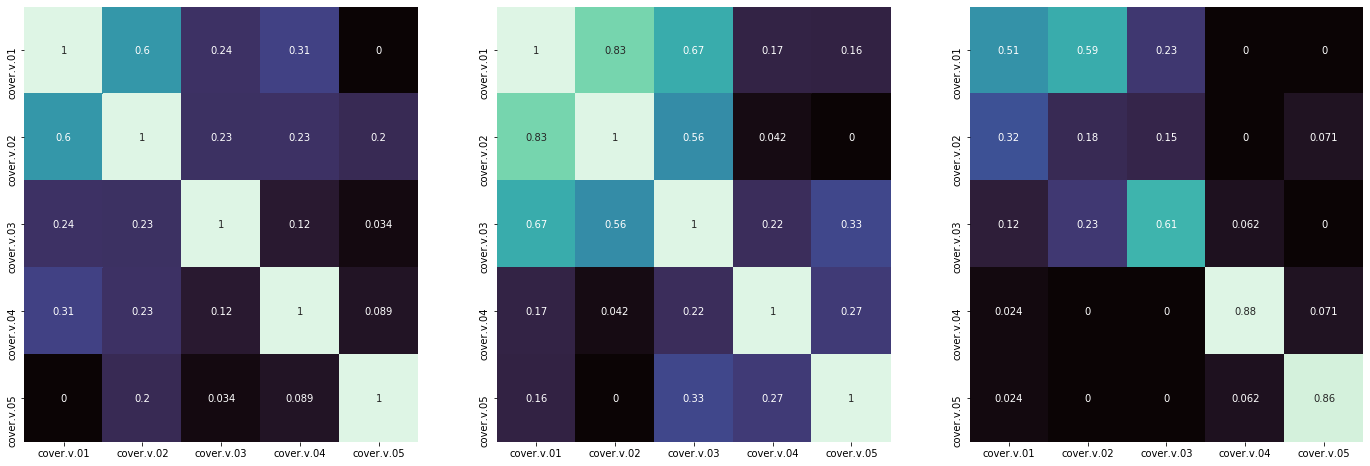

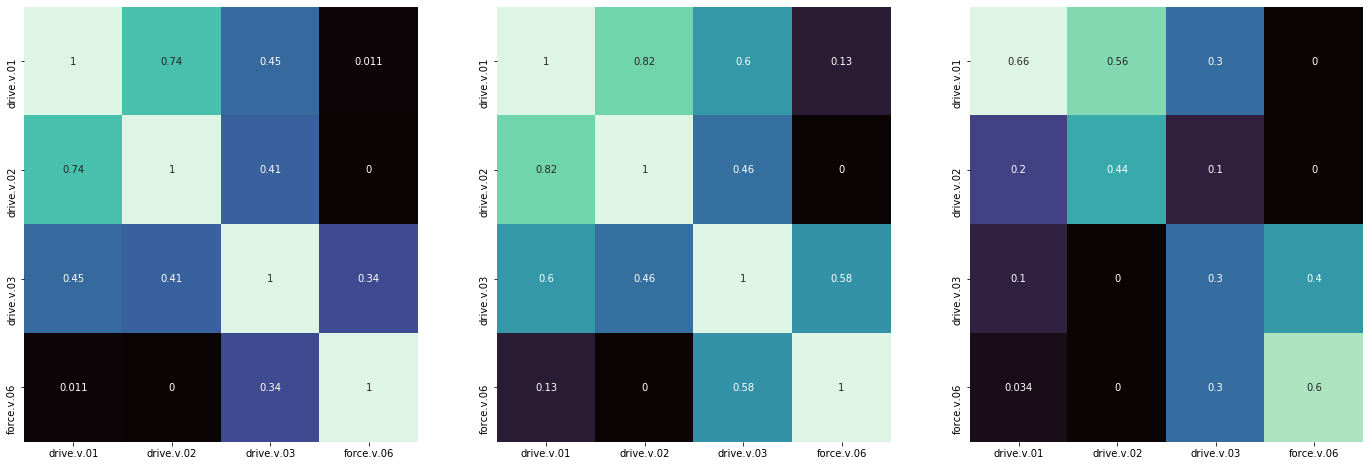

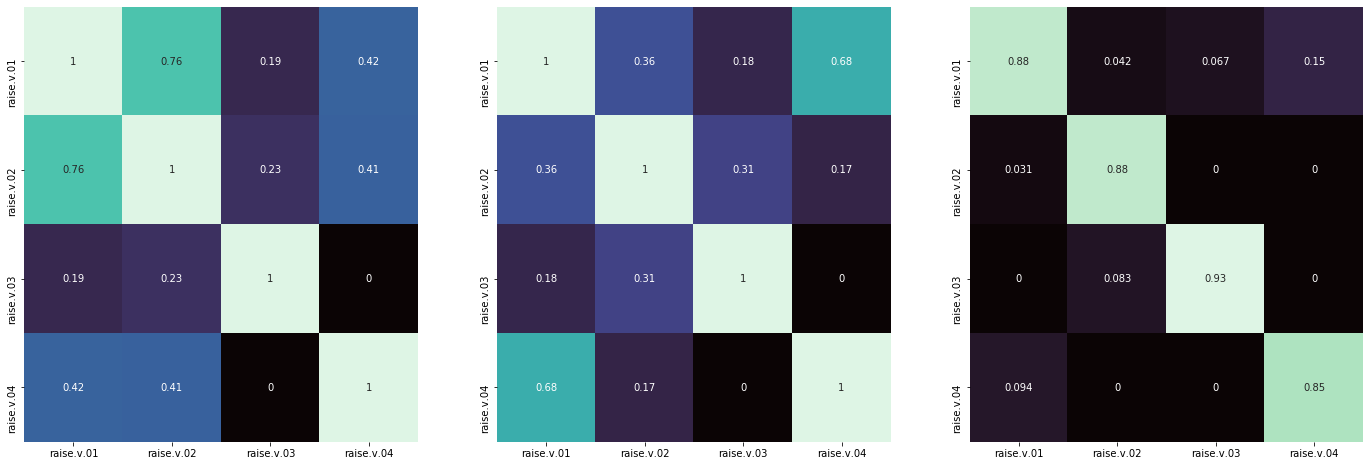

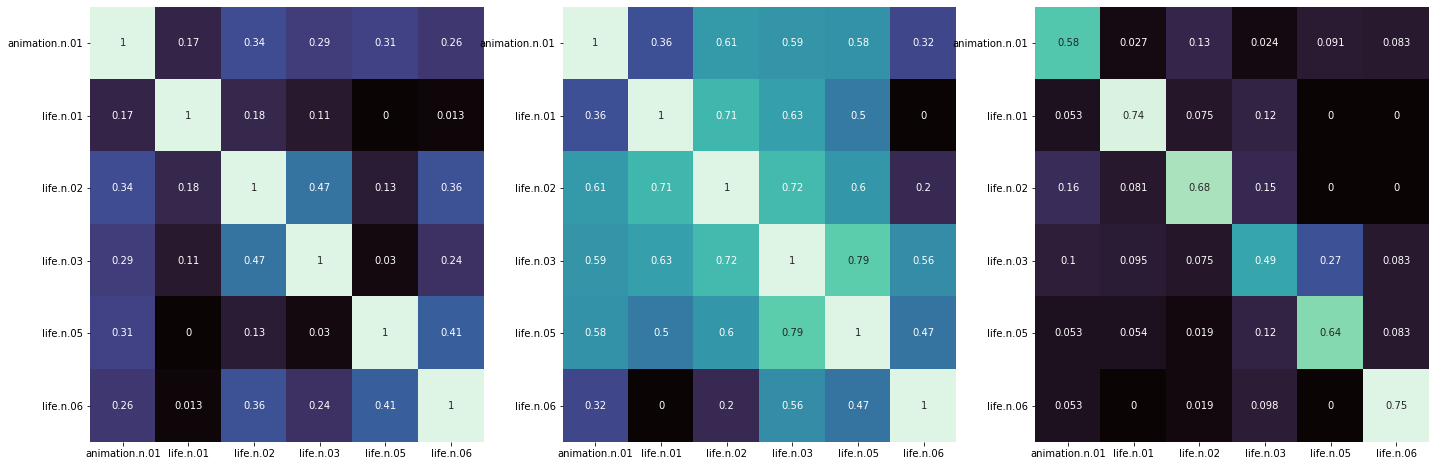

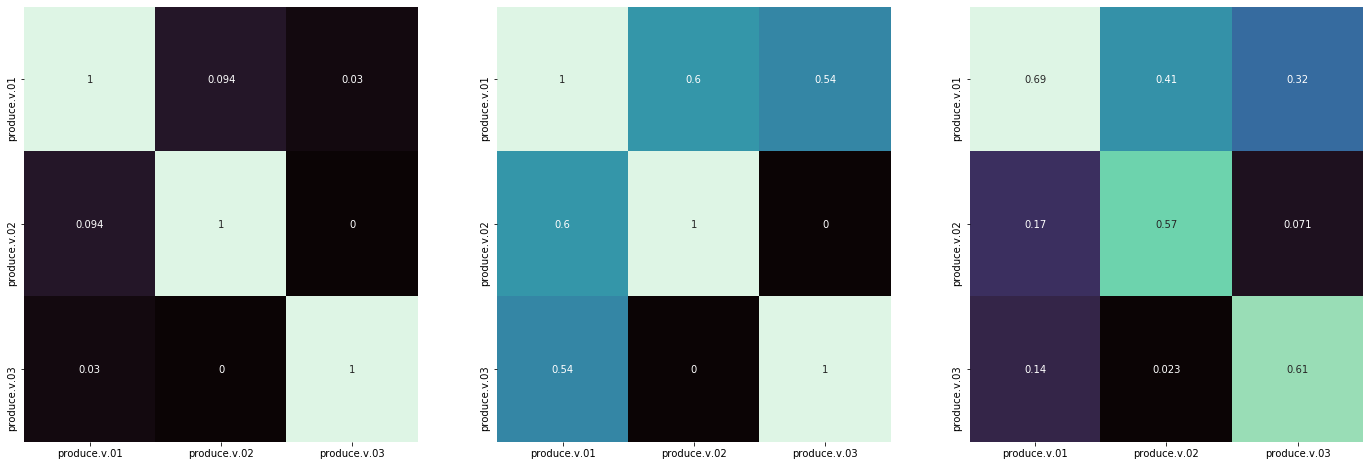

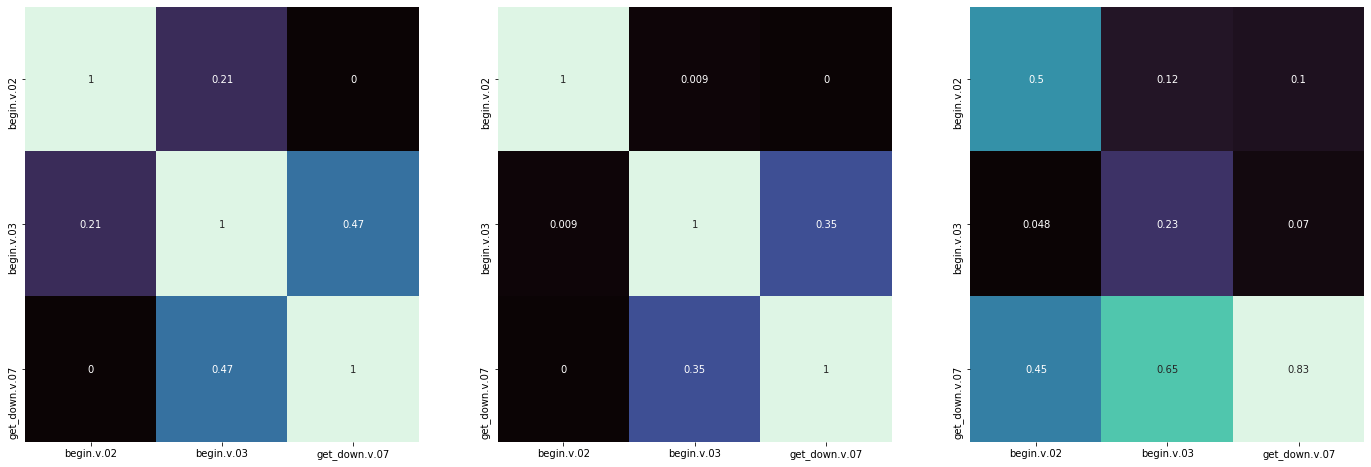

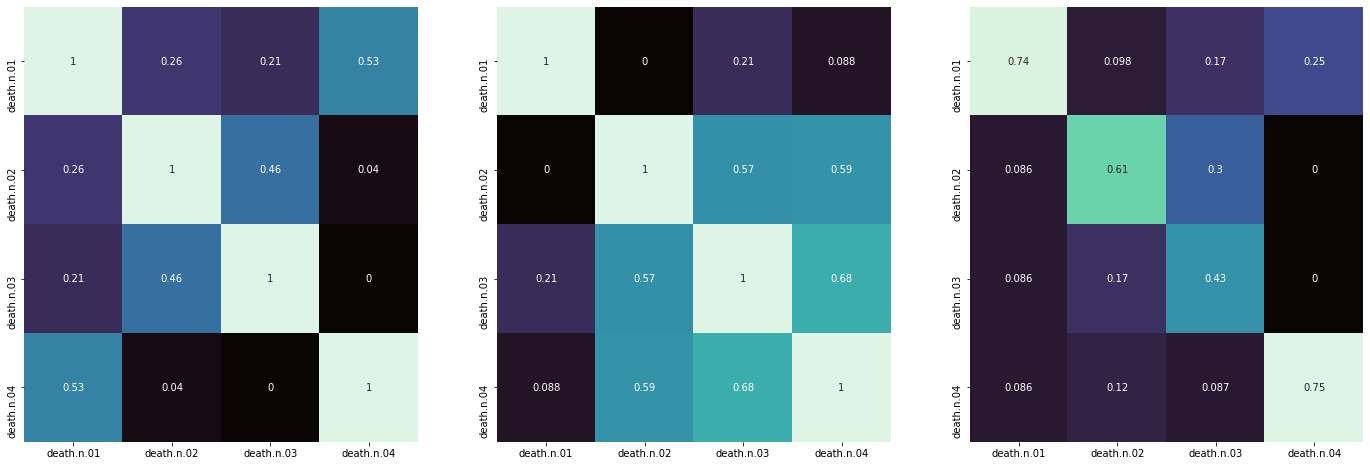

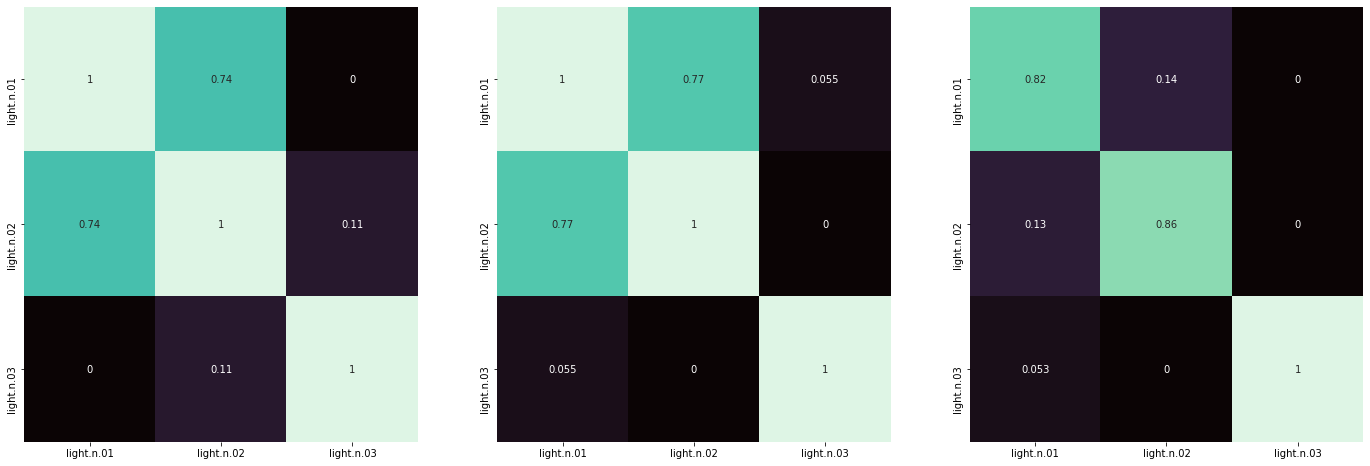

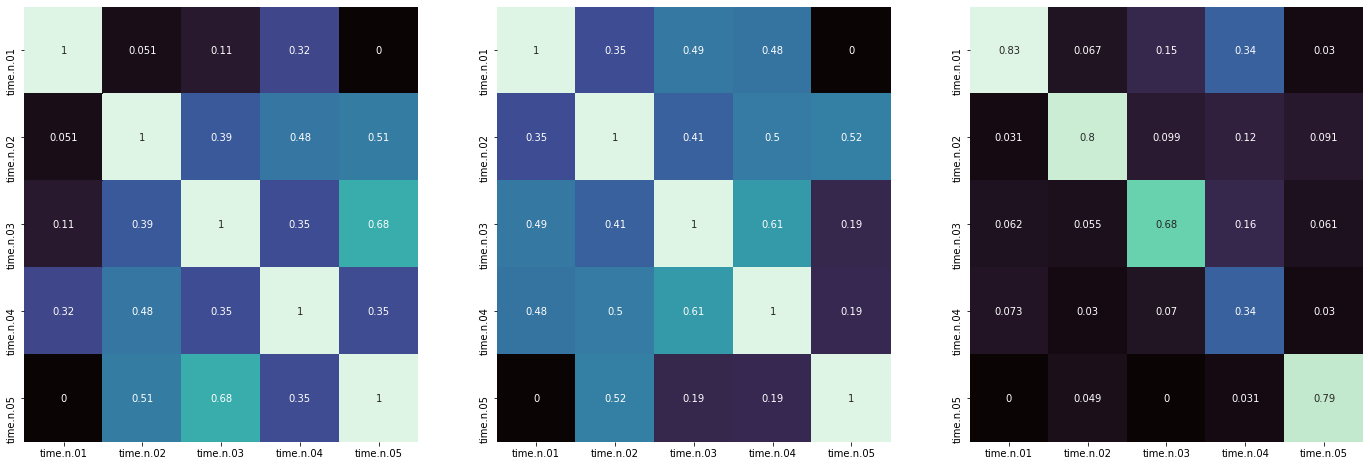

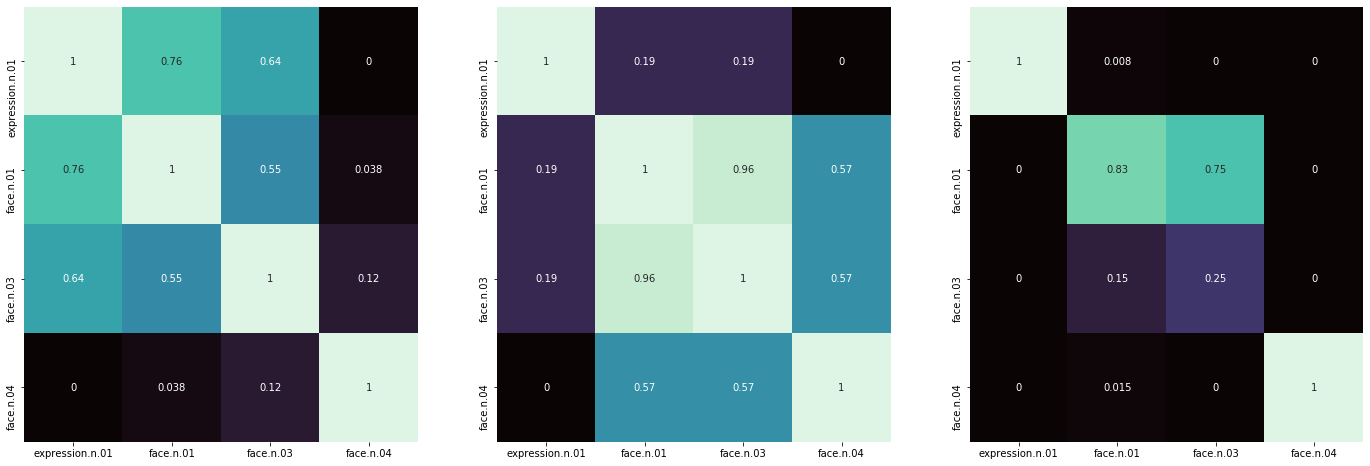

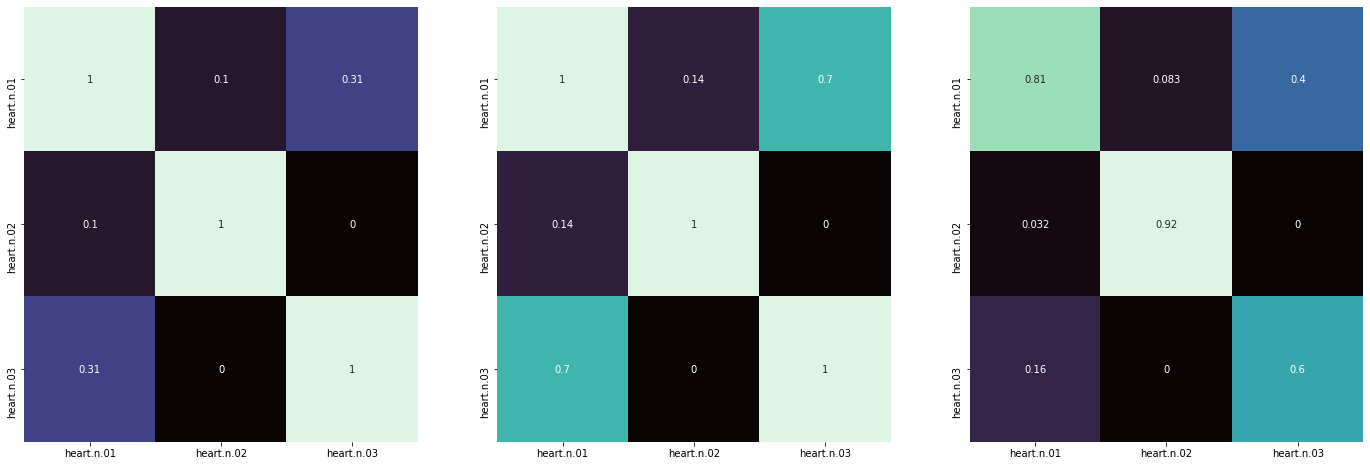

In [179]:
matrices = {w: {} for w in test_words}

with PdfPages('similarities.pdf') as pdf_pages:
    for w in test_words:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))

        avg_reported = get_test_result_data(results, w, incl_users)
        matrices[w]['expt'] = avg_reported
        senses = np.array([fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))])
        expt_fig = sns.heatmap(mtx_to_df(1 - avg_reported, senses), cmap = 'mako', annot = True,
                               cbar = False, ax = ax1)
        #reordered_sense_indices = cg.dendrogram_row.reordered_ind
        
        word, pos = w.split("_")
        bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = senses,
                                             corpus = 'select_weights', use_masc = False)
        bert_cs = normalize_cos_dist(bert_cs)
        matrices[w]['bert'] = bert_cs
        bcs_fig = sns.heatmap(mtx_to_df(1 - bert_cs, senses), ax = ax2, annot = True, cmap = 'mako', cbar = False)

        word_matrices = model_data[w]['confusion_matrices']
        agg_confusion = np.sum(np.asarray(word_matrices), axis = 0)
        agg_confusion = np.nan_to_num(agg_confusion / np.sum(agg_confusion, axis = 0))
        conf_fig = sns.heatmap(mtx_to_df(agg_confusion, senses), cmap = 'mako', ax = ax3, annot = True,
                               cbar = False)
        pdf_pages.savefig(fig)

## Comparison of Embeddings with Nonzero Weights to Experimental Data

Saving values at nonzero weights

In [43]:
from core.semcor_bert_pipeline import save_embeds_with_wts

We print the percent of weights that are nonzero for the embeddings of each type

In [52]:
for w in model_data.keys():
    results = model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w.replace('_', '.'))

door.n 0.17578125
world.n 0.1875
ask.v 0.53125
indicate.v 0.23046875
consider.v 0.2981770833333333
case.n 0.16536458333333334
glass.n 0.049479166666666664
book.n 0.07552083333333333
school.n 0.18619791666666666
put.v 0.3255208333333333
area.n 0.24869791666666666
cover.v 0.13151041666666666
drive.v 0.13541666666666666
raise.v 0.109375
life.n 0.2734375
produce.v 0.16927083333333334
begin.v 0.4674479166666667
death.n 0.13411458333333334
light.n 0.08984375
time.n 0.6419270833333334
face.n 0.18489583333333334
heart.n 0.078125


In [106]:
matrices = {w: {} for w in test_words}

for w in test_words:
    test_means = mean_distance_mtx(results, w, 'test', incl_users, normalize = True)
    repeat_means = mean_distance_mtx(results, w, 'repeat', incl_users, normalize = True)
    expt_means = np.mean([test_means, repeat_means], axis = 0)
    matrices[w]['expt'] = expt_means / np.max(expt_means)
    
    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))],
                                         corpus = 'select_weights', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs


For all test words (r for full embeddings was 0.43)

In [110]:
all_human_avg = [matrices[w]['expt'] for w in test_words]
all_bert_cs = [matrices[w]['bert'] for w in test_words]
bert_human_test = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')
bert_human_test

0.3779306106607573

Text(0.5, 0, "Pearson's R")

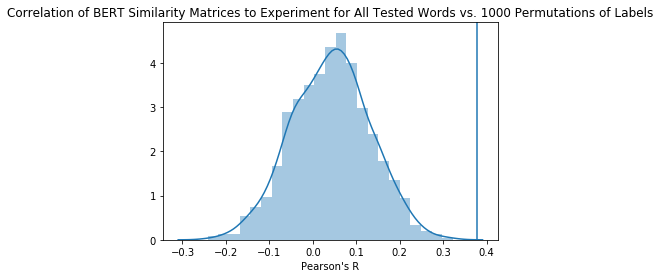

In [111]:
permuted_bert_entries = [mtx_correlation(all_bert_cs, all_human_avg,
                                         method = 'pearson', randomize_m1_labels = True) for i in range(1000)]
sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_test)
plt.title("Correlation of BERT Similarity Matrices to Experiment for All Tested Words vs. 1000 Permutations of Labels")
plt.xlabel("Pearson's R")

In [115]:
results['num_senses'] = results['lemma'].apply(get_num_senses, args = [db])
results['pos'] = results['lemma'].apply(semcor_bert_pipeline.get_pos, args = ['_'])
all_trials = results[results['lemma'].isin(test_words) & (results['userID'].isin(incl_users))]

Full embeddings for nouns r = 0.33, verbs r = 0.59

In [116]:
containing_query(all_trials, 'pos', ['n'], matrices)

0.2544925589473218

In [117]:
containing_query(all_trials, 'pos', ['v'], matrices)

0.5510603444734599

Text(0.5, 1.0, 'Correlation between BERT and Averaged Experimental Data vs. Number of Senses')

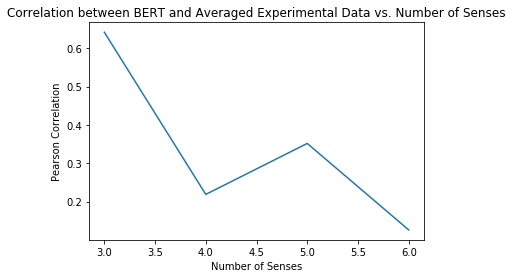

In [118]:
plt.plot(range(3, 7), [containing_query(all_trials, 'num_senses', [i], matrices) for i in range(3, 7)])
plt.xlabel("Number of Senses")
plt.ylabel("Pearson Correlation")
plt.title("Correlation between BERT and Averaged Experimental Data vs. Number of Senses")

In [119]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['lemma'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
semcor_entropy.drop('Lemma', axis = 1, inplace = True)
all_entropy = all_trials.merge(semcor_entropy, on = 'lemma')

High entropy r = 0.18, Low/Medium entropy = 0.69

In [121]:
range_query(all_entropy, 'entropy', 1.45, 2.5, matrices)

0.16031056442332312

In [122]:
range_query(all_entropy, 'entropy', 0, 1.45, matrices)

0.5971329229480942